In [23]:
# package for text nltk
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding,LSTM ,SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [62]:
data= pd.read_csv('amazon_alexa.tsv', sep='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [63]:
# define problem supervisied classification  +ve _   -ve
def sentiments(df):
  if df['rating']>3.0:
    return 'Positive'
  else:
    return 'Negative'

data['sentiment']=data.apply(sentiments,axis=1)

In [64]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [72]:
data_v1=data[['verified_reviews','sentiment']]

In [73]:
data_v1.head()

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive


In [74]:
# check nulls
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [75]:
# preprocessing data   World world WORLD   lower case or upper case
def cleaning(df,stop_words):
  # lower case all the words
  df['verified_reviews']=df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

  # replace special character 
  df['verified_reviews']=df['verified_reviews'] .str.replace('[^\w\s]','')

  # replace the digits and numbers
  df['verified_reviews']=df['verified_reviews'] .str.replace('d','')  
  # remove stop words 
  df['verified_reviews']=df['verified_reviews'].apply(lambda x:' '.join([ x for x in x.split()  if x not in stop_words]))


  # lemmatization
  df['verified_reviews']=df['verified_reviews'].apply(lambda x:" ".join([Word(x).lemmatize() for x in x.split()]))

  return df

In [76]:
stop_words=stopwords.words('english')

In [77]:
data_v1=cleaning(data_v1,stop_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: Setting

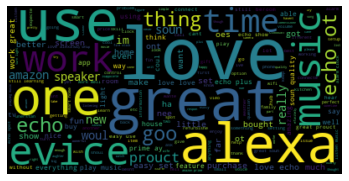

In [78]:
# visualising the corpus
import wordcloud
common_words=''

for i in data_v1.verified_reviews:
  i=str(i)
  tokens=i.split()
  common_words+= " ".join(tokens)+" "

wordcloud=wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [79]:
# classification 
lb=LabelEncoder()
data_v1['sentiment']=lb.fit_transform(data_v1['sentiment'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
# convert text to vector
tokenizer=Tokenizer(num_words=500,split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X= tokenizer .texts_to_sequences(data_v1['verified_reviews'].values)
X=pad_sequences(X)

In [89]:
model=Sequential()
model.add(Embedding(500,120,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 161, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 161, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________


In [90]:
y=pd.get_dummies(data_v1['sentiment'])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [91]:
model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
74/74 [==============================] - 90s 1s/step - loss: 0.3717 - accuracy: 0.8713
Epoch 2/5
74/74 [==============================] - 52s 705ms/step - loss: 0.2644 - accuracy: 0.8954
Epoch 3/5
74/74 [==============================] - 53s 711ms/step - loss: 0.2133 - accuracy: 0.9141
Epoch 4/5
74/74 [==============================] - 52s 696ms/step - loss: 0.1673 - accuracy: 0.9323
Epoch 5/5
74/74 [==============================] - 53s 716ms/step - loss: 0.1524 - accuracy: 0.9454


In [92]:
model.evaluate(X_test,y_test)

25/25 [==============================] - 5s 167ms/step - loss: 0.2793 - accuracy: 0.8883


[0.27928197383880615, 0.8883248567581177]

In [93]:
X.shape

(3150, 161)

In [94]:
model.save('sentiment-analysis')

INFO:tensorflow:Assets written to: sentiment-analysis/assets


In [96]:
!zip -r /content/sentiment-analysis


zip error: Nothing to do! (/content/sentiment-analysis.zip)


In [97]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [98]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 87%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 60%)
